# Dynamic Pricing Model Using Thompson Sampling
We implement a dynamic price optimization model for descrete price levels using Thompson sampling.

### Data
We use an internal simulator. No external datasets are used.

### Papers
1. Ferreira K., Simchi-Levi D., and Wang H. -- Online Network Revenue Management Using Thompson Sampling, November 2017

In [1]:
import numpy as np
from tabulate import tabulate
from scipy.optimize import linprog
import scipy.stats as stats 
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation

np.set_printoptions(precision=2)

def tabprint(msg, A):
    print(msg)
    print(tabulate(A, tablefmt="fancy_grid"))
    
#plt.rcParams.update({'font.family':'Candara', 'font.serif':['Candara']})
#plt.rcParams.update({'pdf.fonttype': 'truetype', 'font.size': 18})

# Step 1: Determine Optimal Prices Using Numerical Optimization

In [2]:
# Find the optimal distribution of prices (price probabilities) given fixed price levels, 
# corresponding demand levels, and availbale product inventory.
# 
# Inputs:
#   prices, demands, and revenues are vectors (i-th element corresponds to i-th price level)
#   inventory is a scalar (number of availbale units)
def optimal_price_probabilities(prices, demands, inventory):   
    
    revenues = np.multiply(prices, demands)
    
    L = len(prices)
    M = np.full([1, L], 1)
    B = [[1]]
    Df = [demands]

    res = linprog(-np.array(revenues).flatten(), 
                  A_eq=M, 
                  b_eq=B, 
                  A_ub=Df, 
                  b_ub=np.array([inventory]), 
                  bounds=(0, None))

    price_prob = np.array(res.x).reshape(1, L).flatten()
    
    return price_prob

In [5]:
# Optimization procedure test
prices = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
demands = list(map(lambda p: np.exp(-0.02473518*p + 5.47213038), prices))
revenues = np.multiply(prices, demands)
print(demands)
print(revenues)
print(optimal_price_probabilities(prices, demands, 60000))

[237.37872512366351, 236.79229015198067, 236.20730394524412, 235.62376292433646, 235.04166351898155, 234.46100216772422, 233.88177531790694, 233.30397942564977, 232.72761095582692]
[ 23.74  47.36  70.86  94.25 117.52 140.68 163.72 186.64 209.45]
[2.68e-10 3.42e-10 4.75e-10 7.17e-10 1.18e-09 2.13e-09 4.02e-09 3.10e-10
 1.00e+00]


# Step 2: Optimize Prices Dynamically Using Thompson Sampling 

In [6]:
prices = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Hidden (true) demand parameters - a linear demans function is assumed
demand_a = -0.02473518
demand_b = 5.47213038

# prior distribution for each price - gamma(α, β)
θ = []
for p in prices:
    θ.append({'price': p, 'alpha': 30.00, 'beta': 1.00, 'mean': 30.00})

def gamma(alpha, beta):
    shape = alpha
    scale = 1/beta
    return np.random.gamma(shape, scale)

def sample_demand(price):
    demand = np.exp(demand_a - demand_b * price)
    return np.random.poisson(demand, 1)[0]

def sample_demands_from_model(θ):
    return list(map(lambda v: gamma(v['alpha'], v['beta']), θ))
        
T = 200
history = []
for t in range(0, T):              # simulation loop
    demands = sample_demands_from_model(θ)
    print(tabulate(np.array(θ), tablefmt="fancy_grid"))
    
    print("demands = ", np.array(demands))
    
    price_probs = optimal_price_probabilities(prices, demands, 6000)
    
    print(sum(price_probs))
    
    # select one best price
    price_index_t = np.random.choice(len(prices), 1, p=price_probs)[0]
    price_t = prices[price_index_t]
    
    # sell at the selected price and observe demand
    demand_t = sample_demand(price_t)
    print('selected price %.2f => demand %.2f, revenue %.2f' % (price_t, demand_t, demand_t*price_t))
    
    theta_trace = []
    for v in θ:
        theta_trace.append(v.copy())
    history.append([price_t, demand_t, demand_t*price_t, theta_trace])
    
    # update model parameters
    v = θ[price_index_t]
    v['alpha'] = v['alpha'] + demand_t
    v['beta'] = v['beta'] + 1
    v['mean'] = v['alpha'] / v['beta']
    
    print("")

╒═════╤════╤═══╤════╕
│ 0.1 │ 30 │ 1 │ 30 │
├─────┼────┼───┼────┤
│ 0.2 │ 30 │ 1 │ 30 │
├─────┼────┼───┼────┤
│ 0.3 │ 30 │ 1 │ 30 │
├─────┼────┼───┼────┤
│ 0.4 │ 30 │ 1 │ 30 │
├─────┼────┼───┼────┤
│ 0.5 │ 30 │ 1 │ 30 │
├─────┼────┼───┼────┤
│ 0.6 │ 30 │ 1 │ 30 │
├─────┼────┼───┼────┤
│ 0.7 │ 30 │ 1 │ 30 │
├─────┼────┼───┼────┤
│ 0.8 │ 30 │ 1 │ 30 │
├─────┼────┼───┼────┤
│ 0.9 │ 30 │ 1 │ 30 │
╘═════╧════╧═══╧════╛
demands =  [32.08 32.42 24.73 29.25 30.25 42.07 20.97 33.26 28.71]
1.000000000001701
selected price 0.80 => demand 0.00, revenue 0.00

╒═════╤════╤═══╤════╕
│ 0.1 │ 30 │ 1 │ 30 │
├─────┼────┼───┼────┤
│ 0.2 │ 30 │ 1 │ 30 │
├─────┼────┼───┼────┤
│ 0.3 │ 30 │ 1 │ 30 │
├─────┼────┼───┼────┤
│ 0.4 │ 30 │ 1 │ 30 │
├─────┼────┼───┼────┤
│ 0.5 │ 30 │ 1 │ 30 │
├─────┼────┼───┼────┤
│ 0.6 │ 30 │ 1 │ 30 │
├─────┼────┼───┼────┤
│ 0.7 │ 30 │ 1 │ 30 │
├─────┼────┼───┼────┤
│ 0.8 │ 30 │ 2 │ 15 │
├─────┼────┼───┼────┤
│ 0.9 │ 30 │ 1 │ 30 │
╘═════╧════╧═══╧════╛
demands =  [21.35 36.51 26.13

1.0000000002984109
selected price 0.70 => demand 0.00, revenue 0.00

╒═════╤════╤════╤═════════╕
│ 0.1 │ 30 │  4 │ 7.5     │
├─────┼────┼────┼─────────┤
│ 0.2 │ 32 │  7 │ 4.57143 │
├─────┼────┼────┼─────────┤
│ 0.3 │ 31 │ 10 │ 3.1     │
├─────┼────┼────┼─────────┤
│ 0.4 │ 30 │ 11 │ 2.72727 │
├─────┼────┼────┼─────────┤
│ 0.5 │ 31 │ 13 │ 2.38462 │
├─────┼────┼────┼─────────┤
│ 0.6 │ 30 │ 15 │ 2       │
├─────┼────┼────┼─────────┤
│ 0.7 │ 30 │ 19 │ 1.57895 │
├─────┼────┼────┼─────────┤
│ 0.8 │ 30 │ 22 │ 1.36364 │
├─────┼────┼────┼─────────┤
│ 0.9 │ 30 │ 23 │ 1.30435 │
╘═════╧════╧════╧═════════╛
demands =  [7.5  4.68 2.68 2.86 3.28 1.74 1.62 1.48 1.4 ]
1.0000000002511549
selected price 0.50 => demand 0.00, revenue 0.00

╒═════╤════╤════╤═════════╕
│ 0.1 │ 30 │  4 │ 7.5     │
├─────┼────┼────┼─────────┤
│ 0.2 │ 32 │  7 │ 4.57143 │
├─────┼────┼────┼─────────┤
│ 0.3 │ 31 │ 10 │ 3.1     │
├─────┼────┼────┼─────────┤
│ 0.4 │ 30 │ 11 │ 2.72727 │
├─────┼────┼────┼─────────┤
│ 0.5 │ 31 │ 14 │ 2.

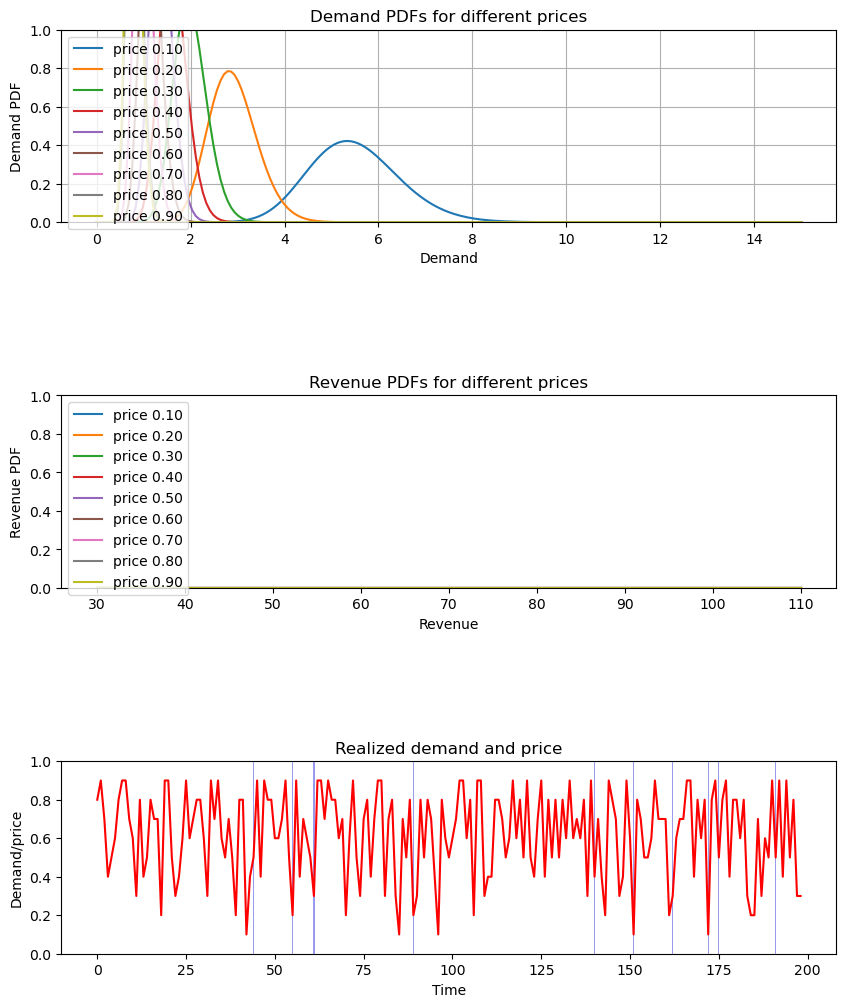

In [7]:
def visualize_snapshot(t):
    plt.subplot(3, 1, 1)
    plt.xlabel('Demand')
    plt.ylabel('Demand PDF')
    plt.title('Demand PDFs for different prices')
    x = np.linspace(0, 15, 200) 
    for i, params in enumerate(history[t][3]):
        y = stats.gamma.pdf(x, a=params['alpha'], scale=1.0/params['beta']) 
        plt.plot(x, y, "-", label='price %.2f' % params['price']) 
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.xlabel('Revenue')
    plt.ylabel('Revenue PDF')
    plt.title('Revenue PDFs for different prices')
    x = np.linspace(30, 110, 200) 
    for i, params in enumerate(history[t][3]):
        y = stats.gamma.pdf(x, a=params['alpha']*params['price'], scale=1.0/params['beta']) 
        plt.plot(x, y, "-", label='price %.2f' % params['price']) 
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    
    plt.subplot(3, 1, 3)
    plt.xlabel('Time')
    plt.ylabel('Demand/price')
    plt.title('Realized demand and price')
    prices = [h[0] for h in history]
    demands = [h[1] for h in history]
    plt.plot(range(0, t+1), np.array(prices)[0:t+1], 'r-') 
    plt.bar(range(0, T-1), np.pad(np.array(demands)[0:t+1], (0, T-2-t), 'constant'), 0.35, color='#9999ee')
    plt.ylim([0, 1])

fig = plt.figure(figsize = (10, 12))
plt.subplots_adjust(hspace = 0.9)
visualize_snapshot(T - 2)                 # fisualize the final state of the simulation
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


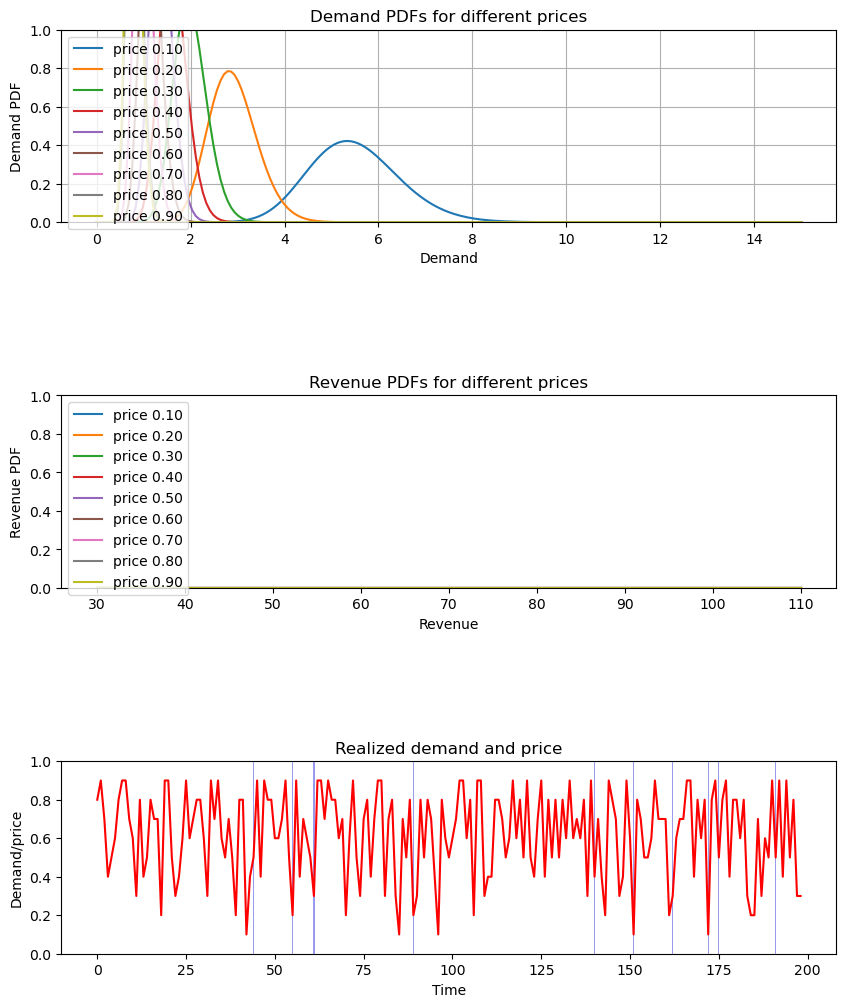

In [8]:
# Render and save the animation of the simulation process

fig = plt.figure(figsize=(10, 12))
plt.subplots_adjust(hspace=0.9)

t = 0
def animate(f):
    global t
    fig.clear()
    visualize_snapshot(t)
    t = t + 1
    
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, bitrate=2800)
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames = T-3, repeat = True)

ani.save('thompson_test_run.gif', writer='imagemagick', fps = 10, dpi = 90)